## import libraries

In [1]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pyemma
from shapeGMM import gmm_shapes
from shapeGMMTorch import torch_sgmm
from shapeGMMTorch import scripts
import MDAnalysis as md
import torch
import pickle

In [2]:
from MDAnalysis.lib.distances import calc_dihedrals
def calc_phi_psi(trajData):
    phis = calc_dihedrals(trajData[:,0,:], trajData[:,1,:], trajData[:,2,:], trajData[:,3,:])*180/3.14
    psis = calc_dihedrals(trajData[:,1,:], trajData[:,2,:], trajData[:,3,:], trajData[:,4,:])*180/3.14
    return phis,psis

# Metadynamics Simulation (Untempered)

### File locations for this simulation ->

In [3]:
data_path = "/scratch/projects/hockygroup/ss12902/metad_sims_ala2_using_same_tpr_TREX/bf1/"
gro_file = "run_ala2_metad_sigma0.3_height1.2_pace500.gro"
traj_file = "run_ala2_metad_sigma0.3_height1.2_pace500_wrapped.trr"
colvar_file = "run_ala2_metad_sigma0.3_height1.2_pace500.colvars.dat"

### load the trajectory for the given atom selction ->

### load the data from COLVAR file ->

In [4]:
time, phi, psi, metad_bias, metad_rbias = np.loadtxt(data_path+colvar_file, usecols=(0,1,2,3,4), unpack=True)
time *= 1e-3      # in ns
phi *= 180/3.14   # in degrees
psi *= 180/3.14   # in degrees

In [5]:
## get the FE landscape
kbt = 0.596161  # @ 300K in kcal/mol unit
range_ = [-180,180]

# use weights from metad_rbias
hist, xedges, yedges = np.histogram2d(phi, psi, bins=30, range=[range_,range_], density=True, weights=np.exp(metad_rbias/kbt))
xgrids = (xedges[1:] + xedges[:-1])/2.0
ygrids = (yedges[1:] + yedges[:-1])/2.0

xx, yy = np.meshgrid(xgrids, ygrids)
fe = -kbt*np.log(hist)
fe -= fe.min()

### load the final bias ->

### get the weights for each case ->

### load the clustered objects (uniform weights) ->

### load the clustered objects (metad.rbias weights) ->

In [6]:
print(data_path)

/scratch/projects/hockygroup/ss12902/metad_sims_ala2_using_same_tpr_TREX/bf1/


In [7]:
wsgmm_list_rbias = []
for i in range(3):
    with open(data_path+"w2/run_with_v1.6.1_kabsch_thresh_1e-1/wsgmm_%dstate.pickle"%(i+2), "rb") as fo:
        wsgmm = pickle.load(fo)
        wsgmm_list_rbias.append(wsgmm)

In [8]:
print(wsgmm_list_rbias[0].train_frame_log_likelihood)
print(wsgmm_list_rbias[0].log_likelihood)

[54.17374875 53.17710591 56.07087064 ... 36.87847597 42.22014401
 55.43002123]
54.871117685141854


In [9]:
train = np.loadtxt(data_path+"w2/run_with_v1.6.1_kabsch_thresh_1e-1/train.dat")[:,1:]
cv = np.loadtxt(data_path+"w2/run_with_v1.6.1_kabsch_thresh_1e-1/cv.dat")[:,1:]

# train
train_mean = np.mean(train, axis=1)
train_std = np.std(train, axis=1)

# cv
cv_mean = np.mean(cv, axis=1)
cv_std = np.std(cv, axis=1)

In [10]:
# load train and cv data where we didn't use weights (or uniform weights)

train_wout = np.loadtxt(data_path+"run_with_v1.6.1_kabsch_thresh_1e-1/train.dat")[:,1:]
cv_wout = np.loadtxt(data_path+"run_with_v1.6.1_kabsch_thresh_1e-1/cv.dat")[:,1:]

# train
train_mean_wout = np.mean(train_wout, axis=1)
train_std_wout = np.std(train_wout, axis=1)

# cv
cv_mean_wout = np.mean(cv_wout, axis=1)
cv_std_wout = np.std(cv_wout, axis=1)

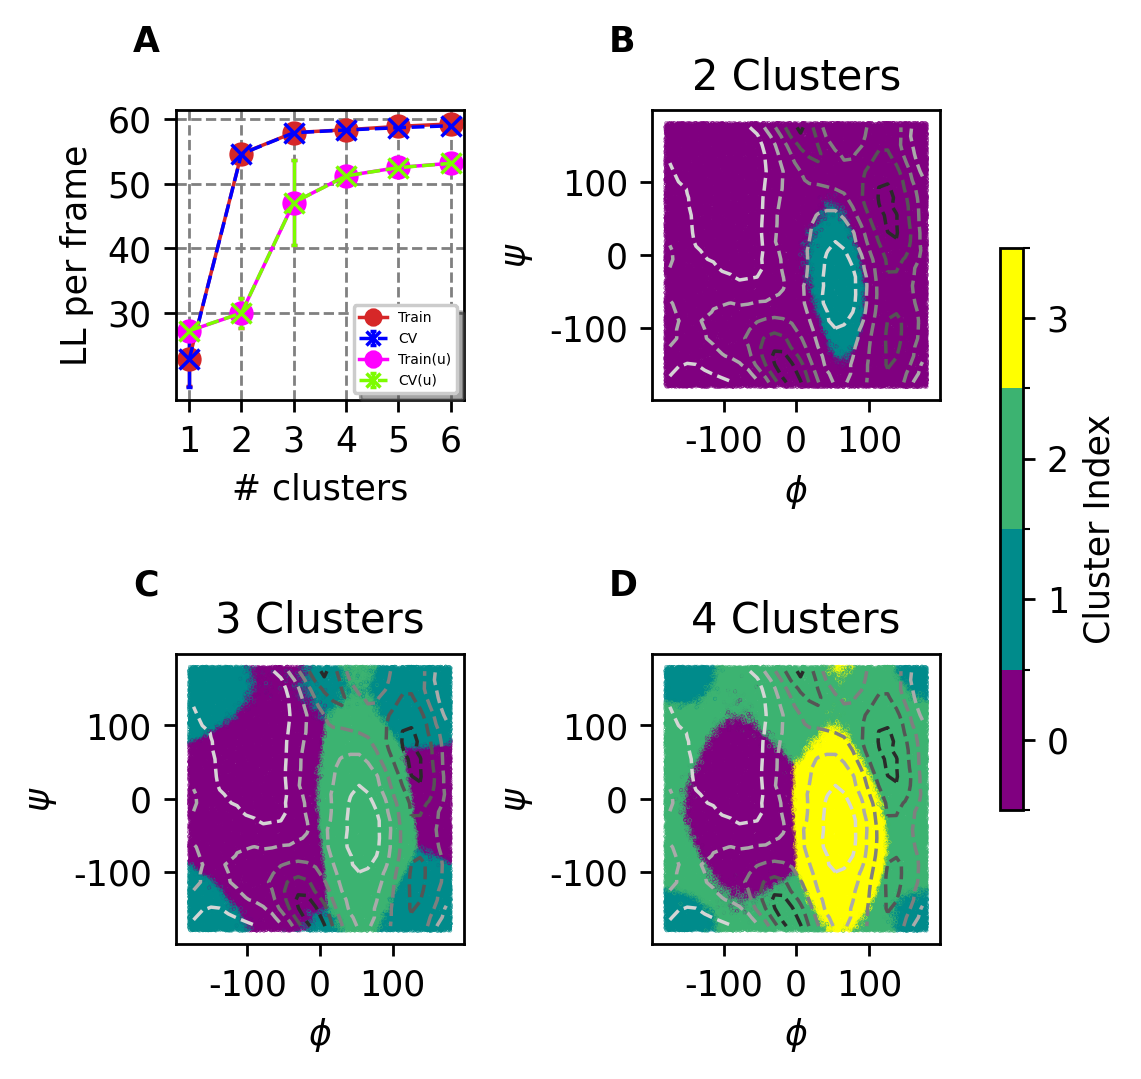

In [11]:
from matplotlib.colors import ListedColormap, BoundaryNorm
import string 

fig, axs = plt.subplots(2,2, figsize=(4.5, 4.5), dpi=250)
axs = axs.reshape([-1])

colors = ['purple', 'darkcyan', 'mediumseagreen', 'yellow']
cluster_boundaries = [0, 1, 2, 3, 4]  # You need one more boundary than the number of colors
cmap = ListedColormap(colors)
norm = BoundaryNorm(cluster_boundaries, cmap.N)


#0
axs[0].text(-0.15, 1.2, "A", fontsize=10, fontweight="bold", transform=axs[0].transAxes)
axs[0].set_xlabel("# clusters")
axs[0].set_ylabel("LL per frame")
axs[0].set_xticks(np.arange(1,7))
axs[0].set_xticklabels(np.arange(1,7))  # change the fontsize on tick labels
axs[0].set_yticks([30,40,50,60])
axs[0].set_yticklabels([30,40,50,60])

axs[0].errorbar(np.arange(1,7), train_mean, train_std, fmt='-o', color="tab:red", lw=1, capsize=1, label="Train")
axs[0].errorbar(np.arange(1,7), cv_mean, cv_std, fmt='--x', color="blue", lw=1, capsize=1, label="CV")

axs[0].errorbar(np.arange(1,7), train_mean_wout, train_std_wout, fmt='-o', color="magenta", lw=1, capsize=1, label="Train(u)")
axs[0].errorbar(np.arange(1,7), cv_mean_wout, cv_std_wout, fmt='--x', color="lawngreen", lw=1, capsize=1, label="CV(u)")

axs[0].legend(loc="lower right", fontsize=4.0, markerscale=0.7, shadow=True)
axs[0].grid(which='major', axis='both', color='#808080', linestyle='--')

labels = ["B", "C", "D"]
for i in range(3):
    if i == 0 or i == 2:
        axs[i+1].set_yticks([])
    axs[i+1].text(-0.15, 1.2, labels[i], fontsize=10, fontweight="bold", transform=axs[i+1].transAxes)
    axs[i+1].set_title("%d Clusters"%(i+2))
    axs[i+1].set_xlabel("$\phi$")
    axs[i+1].set_ylabel("$\psi$")
    axs[i+1].set_yticks([-100,0,100])
    axs[i+1].set_yticklabels([-100,0,100])
    axs[i+1].set_xticks([-100,0,100])
    axs[i+1].set_xticklabels([-100,0,100])
    axs[i+1].contour(xx, yy, fe.T, cmap="binary", linestyles="--", levels=5, linewidths=1.0)
    im = axs[i+1].scatter(phi, psi, c=wsgmm_list_rbias[i].cluster_ids, marker=".", s=0.05, cmap=cmap, norm=norm)

# Create a common colorbar
cbar_ax = fig.add_axes([0.90, 0.25, 0.02, 0.5])  # [x, y, width, height]
cbar = fig.colorbar(im, cax=cbar_ax, ticks=np.arange(0.5, 4, 1))
cbar.set_ticklabels(np.arange(4))
cbar.set_label('Cluster Index')
plt.tight_layout(rect=[0.0,0.0,0.88,1.0])
                                           
#plt.savefig("untempered_all_rbias_weights_updated.png")

# Metadynamics Simulation (BF=10)

### File locations for this simulation ->

In [12]:
data_path = "/scratch/projects/hockygroup/ss12902/metad_sims_ala2_using_same_tpr_TREX/bf10/"
gro_file = "run_ala2_metad_sigma0.3_height1.2_pace500_bf10.gro"
traj_file = "run_ala2_metad_sigma0.3_height1.2_pace500_bf10_wrapped.trr"
colvar_file = "run_ala2_metad_sigma0.3_height1.2_pace500_bf10.colvars.dat"

### load the trajectory for the given atom selction ->

### load the data from COLVAR file ->

In [13]:
time, phi, psi, metad_bias, metad_rbias = np.loadtxt(data_path+colvar_file, usecols=(0,1,2,3,4), unpack=True)
time *= 1e-3      # in ns
phi *= 180/3.14   # in degrees
psi *= 180/3.14   # in degrees

### load the final bias ->

In [14]:
metad_fbias = np.loadtxt(data_path+"colvar_reweight", usecols=3)
metad_fbias -= metad_fbias.min()

In [15]:
# list of biases 
biases = [metad_bias, metad_rbias, metad_fbias]

### calculate the FES for different choice of weights ->

In [16]:
nbins = 30
range_ = [-180,180]
fes_data = []
for i in range(4):
    
    if i == 0:
        # not using any weights
        hist, xedges, yedges = np.histogram2d(phi, psi, bins=[nbins,nbins], range=[range_,range_], density=True)
    else:
        # using proper weights
        hist, xedges, yedges = np.histogram2d(phi, psi, bins=[nbins,nbins], range=[range_,range_], density=True, weights=np.exp(biases[i-1]/kbt))
    
    xgrids = (xedges[1:] + xedges[:-1])/2.0
    ygrids = (yedges[1:] + yedges[:-1])/2.0
    
    xx, yy = np.meshgrid(xgrids, ygrids)
    fe = -kbt*np.log(hist)
    fe -= fe.min()
    
    out_arr = [xx, yy, fe]
    fes_data.append(out_arr)
fes_data = np.array(fes_data)
print(fes_data.shape)

(4, 3, 30, 30)


### load the clustered objects for different weights and different clusters ->

In [17]:
wsgmm_list = []

# loop over different weights (w1, w2 and w3)
for i in range(3):
    objs = []
    
    # loop over different clusters (2 to 6)
    for j in range(5):
        
        # load pickled object
        with open(data_path+"w%d/run_with_v1.6.1/kabsch_thresh_1e-1/wsgmm_%dstate_nattempts_40.pickle"%(i+1, j+2), "rb") as fo:
            obj = pickle.load(fo)
        
        objs.append(obj)
    
    wsgmm_list.append(objs)
        
wsgmm_list = np.array(wsgmm_list)
print(wsgmm_list.shape)

(3, 5)


In [18]:
print(data_path)

/scratch/projects/hockygroup/ss12902/metad_sims_ala2_using_same_tpr_TREX/bf10/


### load the clustered objects obtained from using uniform weights ->

In [19]:
objs_uniform = []
for i in range(5):
    with open(data_path+"run_with_v1.6.1/wsgmm_%dstate_wout_weights_nattempts_40.pickle"%(i+2), "rb") as fo:
        obj_ = pickle.load(fo)
    objs_uniform.append(obj_)
    
objs_uniform = np.array(objs_uniform)

print(objs_uniform.shape)

(5,)


In [20]:
all_wsgmm = np.concatenate([objs_uniform.reshape(1,5), wsgmm_list], axis=0)
print(all_wsgmm.shape)

(4, 5)


In [21]:
print(data_path)

/scratch/projects/hockygroup/ss12902/metad_sims_ala2_using_same_tpr_TREX/bf10/


### load the train and cv files for each case ->

In [22]:
paths = ["run_with_v1.6.1", "w1/run_with_v1.6.1", "w2/run_with_v1.6.1", "w3/run_with_v1.6.1"]
#paths = ["w1", "w2", "w3"]

mean_data = []
std_data = []

for i in range(4):
#for i in range(3):    
    
    # load
    train = np.loadtxt(data_path+paths[i]+"/train.dat")[:,1:]
    cv = np.loadtxt(data_path+paths[i]+"/cv.dat")[:,1:]
    
    # train
    train_mean = np.mean(train, axis=1)
    train_std = np.std(train, axis=1)
    
    # cv
    cv_mean = np.mean(cv, axis=1)
    cv_std = np.std(cv, axis=1)
    
    # append
    mean_data.append([train_mean, cv_mean])
    std_data.append([train_std, cv_std])
    
mean_data = np.array(mean_data)
std_data = np.array(std_data)

In [23]:
print(mean_data.shape)
print(std_data.shape)

(4, 2, 6)
(4, 2, 6)


In [24]:
print(fes_data.shape)
print(all_wsgmm.shape)

(4, 3, 30, 30)
(4, 5)


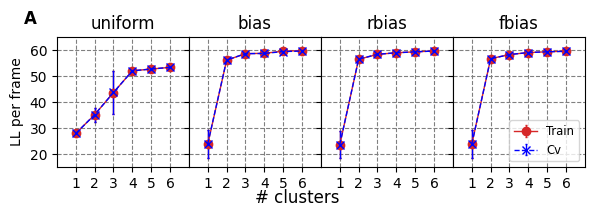

In [25]:
fig, axs = plt.subplots(1, 4, sharex=True, sharey=True, figsize=(6,2.1))
titles = ["uniform", "bias", "rbias", "fbias"]
fig.supxlabel("# clusters")
for i in range(4):
    if i == 0:
        axs[i].text(-0.25, 1.1, string.ascii_uppercase[0], fontsize=12, fontweight="bold", transform=axs[i].transAxes)
        axs[i].set_ylabel("LL per frame")
    axs[i].set_title(titles[i])
    
    # set limits
    axs[i].set_xlim(0,7)
    axs[i].set_ylim(15,65)
    
    # set y-ticks
    axs[i].set_yticks([20,30,40,50,60])
    axs[i].set_yticklabels([20,30,40,50,60])
    
    # set x-ticks
    axs[i].set_xticks(np.arange(1,7))
    axs[i].set_xticklabels(np.arange(1,7))
    
    # plot
    axs[i].errorbar(np.arange(1,7), mean_data[i,0,:], std_data[i,0,:], fmt='-o', color="tab:red", lw=1, capsize=1, label="Train")
    axs[i].errorbar(np.arange(1,7), mean_data[i,1,:], std_data[i,1,:], fmt='--x', color="blue", lw=1, capsize=1, label="Cv")
    if i == 3:
        axs[i].legend(loc="lower right", fontsize="small")
    axs[i].grid(which='major', axis='both', color='#808080', linestyle='--')
fig.subplots_adjust(wspace=0.0, bottom=0.2, right=0.98, left=0.1, top=0.82)
plt.savefig("cluster_scans_difft_bias_adp_updated_2.pdf", format="pdf")

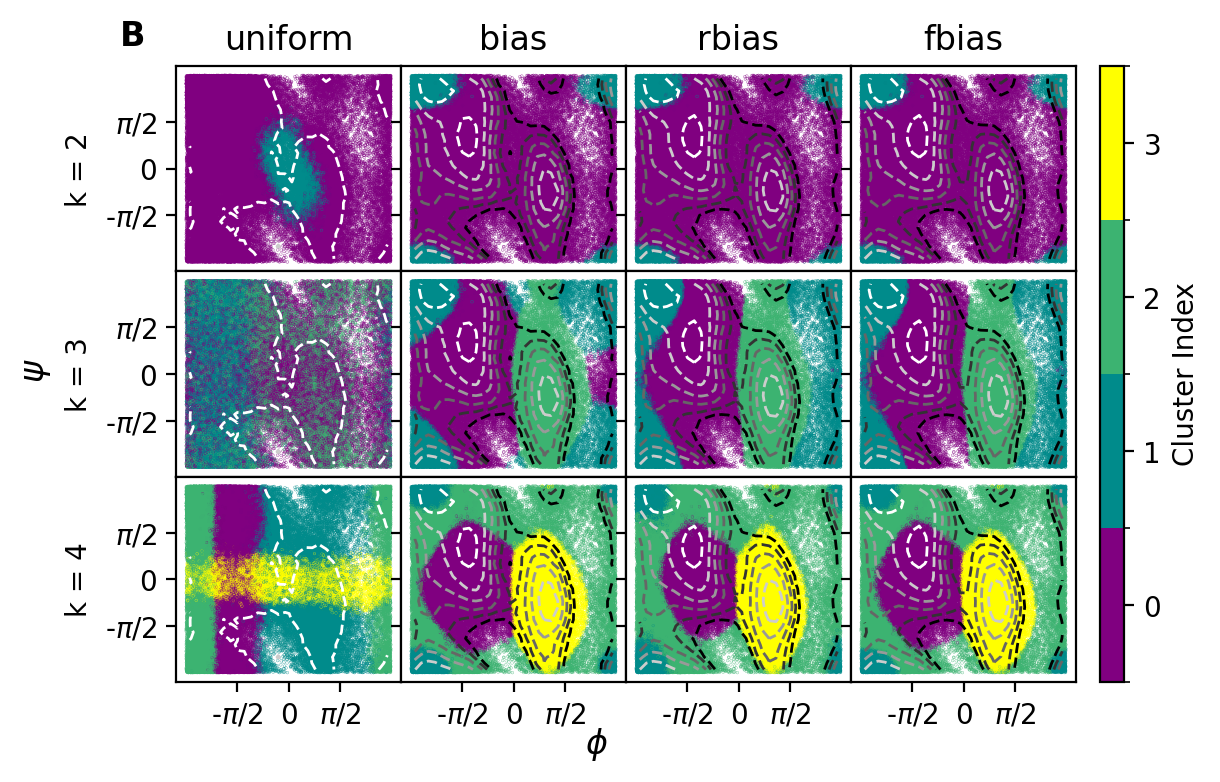

In [26]:
from matplotlib.colors import ListedColormap, BoundaryNorm

#colors = ['purple', 'darkblue', 'darkcyan', 'mediumseagreen', 'limegreen','yellow']
colors = ['purple', 'darkcyan', 'mediumseagreen','yellow']
#colors=["tab:blue", "tab:orange", "tab:green", "tab:olive"]
#cluster_boundaries = [0, 1, 2, 3, 4, 5, 6]  # You need one more boundary than the number of colors
cluster_boundaries = [0, 1, 2, 3, 4]  # You need one more boundary than the number of colors

cmap = ListedColormap(colors)
norm = BoundaryNorm(cluster_boundaries, cmap.N)

fig, axs = plt.subplots(3, 4, figsize=(6,4), sharex=True, sharey=True, dpi=200)
fig.supxlabel("$\phi$")
fig.supylabel("$\psi$")
titles = ["uniform", "bias", "rbias", "fbias"]


axs[0,0].set_xticks([-90,0,90])
axs[0,0].set_xticklabels(["-$\pi/2$", 0, "$\pi/2$"])
axs[0,0].set_yticks([-90,0,90])
axs[0,0].set_yticklabels(["-$\pi/2$", 0, "$\pi/2$"])
axs[0,0].text(-0.25, 1.1, string.ascii_uppercase[1], fontsize=12, fontweight="bold", transform=axs[0,0].transAxes)

# loop over cluster sizes
for i in range(3):
    
    # loop over the different weights
    for j in range(4):
        
        if i == 0:
            axs[i,j].set_title(titles[j])
            
        if j == 0:
            axs[i,j].set_ylabel("k = %d"%(i+2))

        # plot
        #axs[i,j].contour(fes_data[j,0,:,:], fes_data[j,1,:,:], fes_data[j,2,:,:].T, cmap="binary", levels=5, linestyles="--", linewidths=1.0)
        axs[i,j].contour(fes_data[j,0,:,:], fes_data[j,1,:,:], fes_data[j,2,:,:].T, cmap="binary", levels=np.arange(1,12,2), linestyles="--", linewidths=1.0)

        im = axs[i,j].scatter(phi, psi, c=all_wsgmm[j,i].cluster_ids, cmap=cmap, marker=".", s=0.05, norm=norm)
        
# Create a common colorbar
cbar_ax = fig.add_axes([0.92, 0.11, 0.02, 0.77])  # [x, y, width, height]
cbar = fig.colorbar(im, cax=cbar_ax, ticks=np.arange(0.5,4,1))
cbar.set_ticklabels(np.arange(4))

# Optionally, add a label to the colorbar
cbar.set_label('Cluster Index')
fig.subplots_adjust(wspace=0.0, hspace=0.0, left=0.15)
        
plt.savefig("bf10_all_updated_2.png")

In [27]:
print(all_wsgmm.shape)
print(fes_data.shape)

(4, 5)
(4, 3, 30, 30)


### calculate the KL divergences between FEs predicted from GMM and metad sum_hills FE

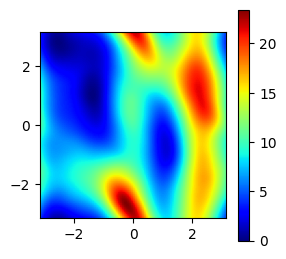

In [28]:
metad_fe_sumhills = np.loadtxt(os.path.join(data_path,"2d_fe_phi_psi_sum_hill_bf10_nbins_100.txt"))[:,2]
metad_fe_sumhills = metad_fe_sumhills.reshape((100,100))
plt.figure(figsize=(3,3))
plt.imshow(metad_fe_sumhills,origin='lower',extent=[-np.pi,np.pi,-np.pi,np.pi], cmap="jet")
plt.colorbar()

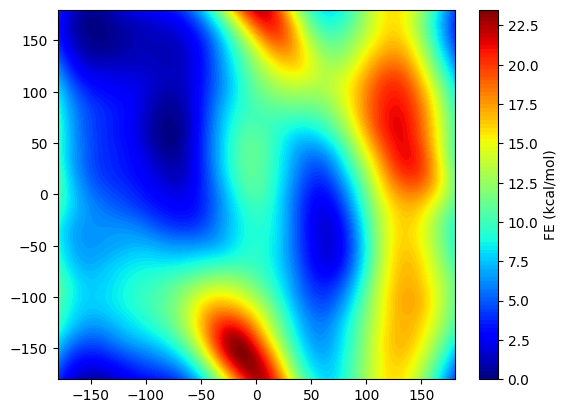

In [29]:
grids_ = np.linspace(-180, 180, 100, endpoint=True, dtype=float)
plt.contourf(grids_, grids_, metad_fe_sumhills, cmap=plt.get_cmap("jet"), levels=100)
cbar = plt.colorbar()
cbar.set_label("FE (kcal/mol)")

In [30]:
print(np.amax(metad_fe_sumhills))

23.415119257


In [31]:
def numerical_integration_2d_simp(fxy,dx,dy):
    #dx and dy could be backwards, but probably identical here
    int_x = np.array([ np.trapz(fxy_i,dx=dx) for fxy_i in fxy ])
    return np.trapz(int_x,dx=dy)

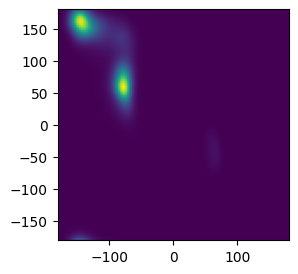

In [32]:
range_=[-180,180]
kt = 0.596161

dx = dy = 2*np.pi/len(metad_fe_sumhills)
prob_metad = np.exp(-metad_fe_sumhills/kt)
prob_metad = prob_metad/numerical_integration_2d_simp(prob_metad,dx,dy)
plt.figure(figsize=(3,3))
plt.imshow(prob_metad,origin='lower',extent=(-180,180,-180,180))

(100, 100)


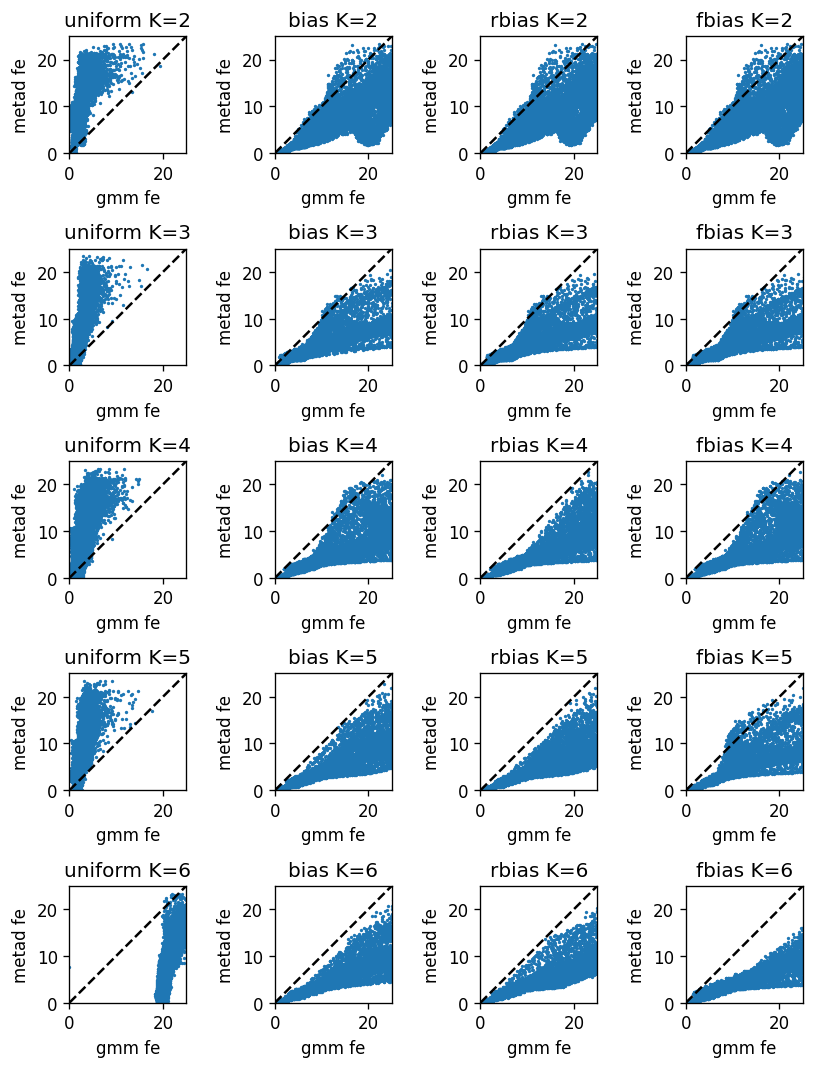

In [33]:
labels = ['uniform','bias','rbias','fbias']
# now get the FEs from SGMM objects ->
fe_sgmm = np.empty((4,5, 100, 100))
kl_errors = np.zeros((4,5))
fig, ax = plt.subplots(5,4,figsize=(7,9),dpi=120)
print(metad_fe_sumhills.shape)
for i in range(4):
    for j in range(5):
        
        H, x, y = np.histogram2d(phi, psi, bins=metad_fe_sumhills.shape, range=[range_, range_], weights=np.exp(all_wsgmm[i,j].train_frame_log_likelihood))
        binweight = np.histogram2d(phi, psi, bins=metad_fe_sumhills.shape, range=[range_, range_], weights=np.ones(phi.shape[0]))[0]
        
        #prob_gmm = H/binweight
        #prob_gmm /= numerical_integration_2d_simp(prob_gmm, dx, dy)
        
        fe = -kt*(np.log(H) - np.log(binweight))
        #fe = -kt*np.log(prob_gmm)
        
        fe -= fe[~np.isnan(fe)].min()
        fe_sgmm[i,j,:,:] = fe

        ax[j,i].scatter(fe.T.flatten(),metad_fe_sumhills.flatten(),s=1)
        ax[j,i].plot(np.arange(0,25,0.1),np.arange(0,25,0.1),linestyle='--',c='k')
        ax[j,i].set_title(f'{labels[i]} K={j+2}')
        ax[j,i].set_xlabel('gmm fe')
        ax[j,i].set_ylabel('metad fe')
        ax[j,i].set_xlim(0,25)
        ax[j,i].set_ylim(0,25)
        ax[j,i].set_box_aspect(1)
        dE = fe.T - metad_fe_sumhills
        dE[np.isnan(dE)]=0
        kl_errors[i,j] = numerical_integration_2d_simp(prob_metad/kt*dE,dx,dy)
        
plt.tight_layout()

In [34]:
print(kl_errors)

[[ 0.17965137  0.90587522  0.90422038  1.47061609 31.60328078]
 [ 3.78812961  2.19949263  3.03861028  3.25430995  3.06121499]
 [ 3.74834595  2.53022195  3.1813027   3.1929948   3.17039244]
 [ 3.84749272  2.60067252  2.99349853  3.05869485  3.3196771 ]]


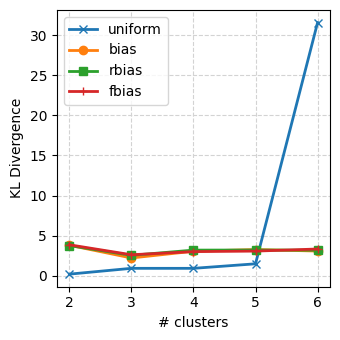

In [35]:
markers = ['x','o','s','+']
plt.figure(figsize=(3.5, 3.5))
plt.xticks([2,3,4,5,6])
plt.ylabel("KL Divergence")
plt.xlabel("# clusters")
plt.grid(axis="both", which="major", linestyle="--", color="lightgrey")
for i in range(4):
    plt.plot([2,3,4,5,6], kl_errors[i,:], label=labels[i], marker=markers[i], lw=2.0)
#plt.ylim(2.5,4.2)
plt.legend(loc=0)
plt.tight_layout()
#plt.savefig("kl_div_fe_sgmm_metad_bf10_all.pdf", format="pdf")

In [36]:
print(fe_sgmm.shape)

(4, 5, 100, 100)


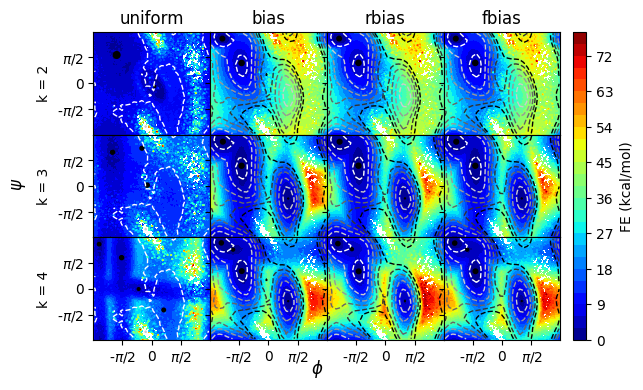

In [41]:
fig, axs  = plt.subplots(3,4, figsize=(6.4,4), sharex=True, sharey=True)
xbins = (x[1:]+x[:-1])/2.0
ybins = (y[1:]+y[:-1])/2.0
bias_labels = ["uniform", "bias", "rbias", "fbias"]
fig.supxlabel("$\phi$")
fig.supylabel("$\psi$")

axs[0,0].set_xticks([-90,0,90])
axs[0,0].set_xticklabels(["-$\pi/2$", 0, "$\pi/2$"])
axs[0,0].set_yticks([-90,0,90])
axs[0,0].set_yticklabels(["-$\pi/2$", 0, "$\pi/2$"])

# loop over sizes
for i in range(3):
    # loop over weights
    for j in range(4):
        
        if i == 0:
            axs[i,j].set_title(bias_labels[j])
            
        if j == 0:
            axs[i,j].set_ylabel("k = %d"%(i+2))
        
        # get phis-psis for cluster centers ->
        phis_centers, psis_centers = calc_phi_psi(all_wsgmm[j,i].centers)
        
        im = axs[i,j].contourf(xbins, ybins, fe_sgmm[j,i].T, cmap="jet", levels=25)
        axs[i,j].scatter(phis_centers, psis_centers, marker="o", s=all_wsgmm[j,i].weights*25.0, color="k")
        axs[i,j].contour(fes_data[j,0,:,:], fes_data[j,1,:,:], fes_data[j,2,:,:].T, cmap="binary", levels=np.arange(1,12,2), linestyles="--", linewidths=1.0)
        
# Create a common colorbar
cbar_ax = fig.add_axes([0.90, 0.11, 0.02, 0.77])  # [x, y, width, height]
cbar = fig.colorbar(im, cax=cbar_ax)

# Optionally, add a label to the colorbar
cbar.set_label('FE (kcal/mol)')
fig.subplots_adjust(wspace=0.0, hspace=0.0, left=0.15, right=0.88)

plt.savefig("fe_sgmm_all_bf10_updated_2.pdf")

In [38]:
print(fe_sgmm.shape)
print(metad_fe_sumhills.shape)

(4, 5, 100, 100)
(100, 100)


## calculate the RMSE between FE profiles -->

In [39]:
rmse_data = np.empty(all_wsgmm.shape)

ref_fes = np.where(metad_fe_sumhills <= 10.0*kt, metad_fe_sumhills, 0).flatten()

# loop over weights
for i in range(4):
    
    # loop over cluster sizes 
    for j in range(5):
        
        a = np.where(metad_fe_sumhills <= 10.0*kt, fe_sgmm[i,j].T, 0).flatten()
        
        dE = a - ref_fes
        #dE[np.isnan(dE)]=0
        dE = np.where(np.isfinite(dE), dE, 0)
        
        rmse_data[i,j] = np.sqrt(np.mean(np.square(dE)))

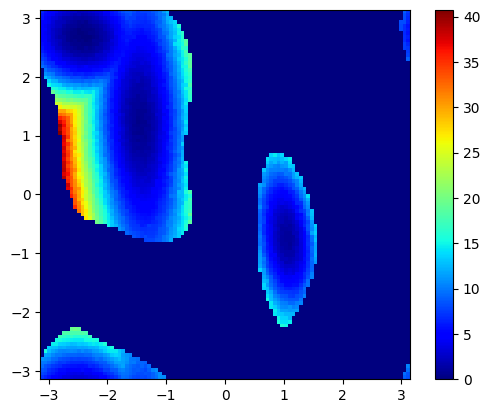

In [40]:
ref_fes = np.where(metad_fe_sumhills <= 10.0*kt, fe_sgmm[1,1].T, 0)
#ref_fes = np.where(metad_fe_sumhills <= 10.0*kt, metad_fe_sumhills, 0)
plt.imshow(ref_fes,origin='lower',extent=[-np.pi,np.pi,-np.pi,np.pi], cmap="jet")
cbar = plt.colorbar()

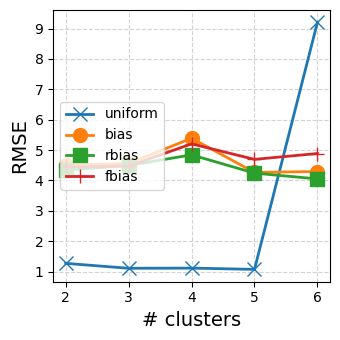

In [41]:
markers = ['x','o','s','+']
plt.figure(figsize=(3.5, 3.5))
plt.xticks([2,3,4,5,6])
plt.ylabel("RMSE", fontsize=14)
plt.xlabel("# clusters", fontsize=14)
plt.grid(axis="both", which="major", linestyle="--", color="lightgrey")
for i in range(4):
    plt.plot([2,3,4,5,6], rmse_data[i,:], label=labels[i], marker=markers[i], lw=2.0, ms=10.0)
#plt.ylim(2.5,4.2)
plt.legend(loc="center left")
plt.tight_layout()
#plt.savefig("rmse_fe_data.pdf", format="pdf")

## check the FES from GMM objects (using MV generator) 

In [42]:
print(all_wsgmm.shape)
print(metad_fe_sumhills.shape)

(4, 5)
(100, 100)


In [43]:
traj_all_bckup = np.load("traj_all_bckup.npy", allow_pickle=True).reshape([4,5,1000000,5,3])
print(traj_all_bckup.shape)

(4, 5, 1000000, 5, 3)


0.0 2.0101851375820825
0.0 5.563970842350338
0.0 5.554187904193216
0.0 5.586479919547765
0.0 1.8971105930422896
0.0 5.562175175330096
0.0 5.544023672494764
0.0 5.565182498579738
0.0 3.9305160225189013
0.0 5.637967500519885
0.0 5.644084402376468
0.0 5.647348778789389


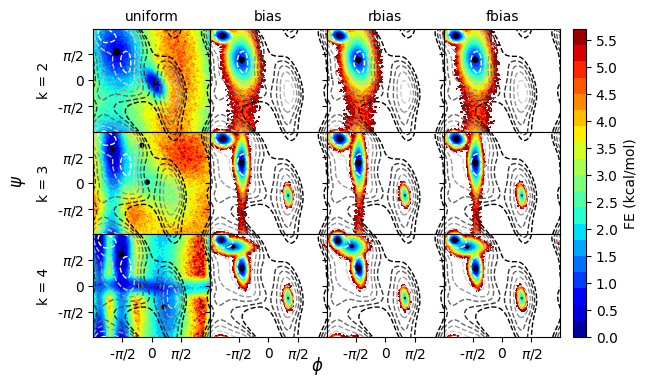

In [50]:
nbins = metad_fe_sumhills.shape
kbt = 0.596161  # @ 300K in kcal/mol unit
range_ = [-180,180]

all_wsgmm_fe_data = np.empty([3, 4, nbins[0], nbins[1]])

fig, axs = plt.subplots(3, 4, figsize=(6.4,4), sharex=True, sharey=True)
fig.supxlabel("$\phi$")
fig.supylabel("$\psi$")
titles = ["uniform", "bias", "rbias", "fbias"]


axs[0,0].set_xticks([-90,0,90])
axs[0,0].set_xticklabels(["-$\pi/2$", 0, "$\pi/2$"])
axs[0,0].set_yticks([-90,0,90])
axs[0,0].set_yticklabels(["-$\pi/2$", 0, "$\pi/2$"])


# it stores the generated traj data for each gmm object
#traj_all_bckup = []
#traj_all_bckup = np.load("traj_all_bckup.npy", allow_pickle=True)

traj_all_bckup = np.load("traj_all_bckup.npy", allow_pickle=True).reshape([4,5,1000000,5,3])

c = 0
# loop over the sizes
for i in range(3):
    
    # loop over the weights
    for j in range(4):
        
        if i ==0 :
            axs[i,j].set_title(titles[j], fontsize=10.0)
        
        if j == 0:
            axs[i,j].set_ylabel("k = %d"%(i+2))
        
        # generate traj (1M samples)
        traj = traj_all_bckup[j,i,:,:,:]
        c += 1 
        
        # get phis-psis
        phis, psis = calc_phi_psi(traj)
        
        # get phis-psis for cluster centers ->
        phis_centers, psis_centers = calc_phi_psi(all_wsgmm[j,i].centers)
        
        # histogram
        hist, xedges, yedges = np.histogram2d(phis, psis, bins=nbins, range=[range_, range_], density=True)

        xcenters = (xedges[1:]+xedges[:-1])/2.0
        ycenters = (yedges[1:]+yedges[:-1])/2.0
        
        fe = -kt*np.log(hist)
        fe -= fe.min()
        
        all_wsgmm_fe_data[i,j] = fe
        
        im = axs[i,j].contourf(xcenters, ycenters, fe.T, cmap="jet", levels=20)        
        print(np.amin(fe), np.amax(fe[np.isfinite(fe)]))
        axs[i,j].contour(xcenters, ycenters, metad_fe_sumhills, cmap="binary", levels=np.arange(1,12,2), linestyles="--", linewidths=1.0)
        axs[i,j].scatter(phis_centers, psis_centers, marker="o", s=all_wsgmm[j,i].weights*25.0, color="k")

        
# Create a common colorbar
cbar_ax = fig.add_axes([0.90, 0.11, 0.02, 0.77])  # [x, y, width, height]
cbar = fig.colorbar(im, cax=cbar_ax)

# Optionally, add a label to the colorbar
cbar.set_label('FE (kcal/mol)')
cbar.set_ticks(np.arange(0, 6, 0.5))
cbar.set_ticklabels(np.arange(0, 6, 0.5))

fig.subplots_adjust(wspace=0.0, hspace=0.0, left=0.15, right=0.88)

plt.savefig("fes_from_gmms_mv_generated_data_bf10_metad_clusters_updated_2.pdf")

In [46]:
rmse_data = np.empty(all_wsgmm.shape)

ref_fes = np.where(metad_fe_sumhills <= 5.0*kt, metad_fe_sumhills, 0).flatten()

# loop over weights
for i in range(4):
    
    # loop over cluster sizes 
    for j in range(5):
        
        a = np.where(metad_fe_sumhills <= 5.0*kt, all_wsgmm_fe_data[i,j].T, 0).flatten()
        
        dE = a - ref_fes
        #dE[np.isnan(dE)]=0
        dE = np.where(np.isfinite(dE), dE, 0)
        print(dE)
        
        rmse_data[i,j] = np.sqrt(np.mean(np.square(dE)))

[ 0.        0.       -2.039747 ...  0.        0.        0.      ]
[0.         0.         2.43239196 ... 0.         0.         0.        ]
[0.         0.         2.42260902 ... 0.         0.         0.        ]
[0.         0.         1.90864424 ... 0.         0.         0.        ]


IndexError: index 4 is out of bounds for axis 1 with size 4

In [ ]:
rmse_data = np.empty(all_wsgmm.shape)

# loop over weights
for i in range(4):
    
    # loop over cluster sizes 
    for j in range(5):
        
        a = np.where(np.isfinite(all_wsgmm_fe_data[i,j].T), all_wsgmm_fe_data[i,j].T, 0).flatten()
        ref_fes = np.where(np.isfinite(all_wsgmm_fe_data[i,j].T), metad_fe_sumhills, 0).flatten()
        
        #a = np.where(all_wsgmm_fe_data[i,j].T <= 5.0*kt, all_wsgmm_fe_data[i,j].T, 0).flatten()
        #ref_fes = np.where(all_wsgmm_fe_data[i,j].T <= 5.0*kt, metad_fe_sumhills, 0).flatten()
        
        dE = a - ref_fes
        #dE[np.isnan(dE)]=0
        dE = np.where(np.isfinite(dE), dE, 0)
        print(dE)
        
        rmse_data[i,j] = np.sqrt(np.mean(np.square(dE)))

In [ ]:
markers = ['x','o','s','+']
plt.figure(figsize=(3.5, 3.5))
plt.xticks([2,3,4,5,6])
plt.ylabel("RMSE (kcal/mol)", fontsize=12)
plt.xlabel("# clusters", fontsize=12)
plt.grid(axis="both", which="major", linestyle="--", color="lightgrey")
for i in range(4):
    plt.plot([2,3,4,5,6], rmse_data[i,:], label=labels[i], marker=markers[i], lw=2.0, ms=10.0)
#plt.ylim(0,0.5)
plt.legend(loc="center left")
plt.tight_layout()
#plt.savefig("rmse_fe_data.pdf", format="pdf")

In [ ]:
print(rmse_data)

In [ ]:
labels = ['uniform','bias','rbias','fbias']
fig, ax = plt.subplots(5,4,figsize=(7,9), sharex=True, sharey=True, dpi=80)

for i in range(4):
    for j in range(5):

        ax[j,i].scatter(all_wsgmm_fe_data[i,j].T.flatten(),metad_fe_sumhills.flatten(),s=1)
        ax[j,i].plot(np.arange(0,25,0.1),np.arange(0,25,0.1),linestyle='--',c='k')
        ax[j,i].set_title(f'{labels[i]} K={j+2}')
        ax[j,i].set_xlabel('gmm fe')
        ax[j,i].set_ylabel('metad fe')
        #ax[j,i].set_xlim(0,25)
        #ax[j,i].set_ylim(0,25)
        #ax[j,i].set_box_aspect(1)
        
plt.tight_layout()

In [ ]:
fig, axs = plt.subplots(2,1, figsize=(3.0,4.2), dpi=100)
axs = axs.reshape([-1])

#0
axs[0].text(-0.2, 1.2, "A", transform=axs[0].transAxes, fontsize=11, fontweight='bold', va='top', ha='left')
axs[0].set_xlabel("$\phi$")
axs[0].set_ylabel("$\psi$")
grids_ = np.linspace(-180, 180, 100, endpoint=True, dtype=float)
im0 = axs[0].contourf(grids_, grids_, metad_fe_sumhills, cmap=plt.get_cmap("jet"), levels=100)
cbar = plt.colorbar(im0, ax=axs[0])
cbar.set_label("FE (kcal/mol)")

#1
axs[1].text(-0.2, 1.2, "B", transform=axs[1].transAxes, fontsize=11, fontweight='bold', va='top', ha='left')
axs[1].set_xlabel("# clusters")
axs[1].set_ylabel("RMSE (kcal/mol)")
axs[1].set_ylim(0,11.0)
axs[1].set_xticks([2,3,4,5,6])
axs[1].set_yticks(np.arange(0,12,2))
axs[1].grid(axis="both", which="major", linestyle="--", color="lightgrey")
for i in range(4):
    axs[1].plot([2,3,4,5,6], rmse_data[i,:], label=labels[i], marker=markers[i], lw=2.0, ms=4.0)
axs[1].legend(fontsize="x-small", ncol=2)

fig.tight_layout()
#fig.tight_layout(rect=[0,0,1,1])
#plt.savefig("rmse_data+ref_fes.pdf", format="pdf")